In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom
import fathon
from fathon import fathonUtils as fu
from scipy.signal import butter, lfilter

# Generate tables

### ENDO

In [18]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

In [19]:
def butter_bandpass(lowcut, highcut, fs, order):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def dfa_alpha(data, min_win=25, max_win=200):
    dfa_data = fu.toAggregated(data)
    pydfa = fathon.DFA(dfa_data)
    wins = fu.linRangeByStep(min_win, max_win)
    n,F = pydfa.computeFlucVec(wins, revSeg=True, polOrd=3)
    H, H_intercept = pydfa.fitFlucVec()
    return H

### Not align

In [22]:
# exclude fixation
endo_fast_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5, 1.5+1+0.5]]
endo_slow_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5, 1.5+1+1]]
exo_fast_stages = [[1.5+0.033*4, 1.5+0.033*4+0.5], [1, 1.5], [1, 1.5]] # the second and third ones are fake, only for occupy the place
exo_slow_stages = [[1.5+0.033*4, 1.5+0.033*4+1], [1, 1.5], [1, 1.5]]

if 'endo' in case_title:
    stages = [endo_fast_stages, endo_slow_stages]
else:
    stages = [exo_fast_stages, exo_slow_stages]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [23]:
dfa_table_se = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for k in range(3): # stages
        print(stages[0][k])
        for i in range(4):
            print(i)
            tmp = np.empty(())
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            for j, data in enumerate([fast_session, slow_session]):
                stage = stages[j][k]
                t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
                for trial_n in range(data.shape[0]):
                    one_trial = data[trial_n, t_start:t_end]
                    alpha = dfa_alpha(one_trial)
                    tmp = np.append(tmp, alpha)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            mask = (tmp>0) & (tmp<2)
            filtered_tmp = tmp[mask]
            dfa_table_num[i, channel, k] = filtered_tmp.shape[0]
            dfa_table_se[i, channel, k] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_'+case_title, dfa_table_se)
np.save('dfa_num_'+case_title, dfa_table_num)


0
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
1
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
2
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
3
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
4
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
5
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
6
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
7
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
8
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
9
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
10
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
11
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
12
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
13
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
14
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
15
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
16
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0

### EXO

In [24]:
case_title = 'exo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5, 1.5+1+0.5]]
endo_slow_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5, 1.5+1+1]]
exo_fast_stages = [[1.5+0.033*4, 1.5+0.033*4+0.5], [1, 1.5], [1, 1.5]] # the second and third ones are fake, only for occupy the place
exo_slow_stages = [[1.5+0.033*4, 1.5+0.033*4+1], [1, 1.5], [1, 1.5]]

if 'endo' in case_title:
    stages = [endo_fast_stages, endo_slow_stages]
else:
    stages = [exo_fast_stages, exo_slow_stages]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

dfa_table_se = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for k in range(3): # stages
        print(stages[0][k])
        for i in range(4):
            print(i)
            tmp = np.empty(())
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            for j, data in enumerate([fast_session, slow_session]):
                stage = stages[j][k]
                t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
                for trial_n in range(data.shape[0]):
                    one_trial = data[trial_n, t_start:t_end]
                    alpha = dfa_alpha(one_trial)
                    tmp = np.append(tmp, alpha)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            mask = (tmp>0) & (tmp<2)
            filtered_tmp = tmp[mask]
            dfa_table_num[i, channel, k] = filtered_tmp.shape[0]
            dfa_table_se[i, channel, k] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_'+case_title, dfa_table_se)
np.save('dfa_num_'+case_title, dfa_table_num)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

0
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
1
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
2
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
3
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
4
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
5
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
6
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
7
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
8
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
9
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
10
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
11
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
12
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
13
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1

### Fixation

In [25]:
case_title = 'all'
case = 'all'

fs = 1200

watch = '1 fixation'
tmin = 0 # include fix or not?
tmax = 1.5

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)


stage = [0, 1.5]
sessions = [sb, sa, rb, ra]

dfa_table_se = np.zeros((4, 32)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for i in range(4):
        print(i)
        tmp = np.empty(())
        data = sessions[i][channel]
        t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
        for trial_n in range(data.shape[0]):
            one_trial = data[trial_n, t_start:t_end]
            alpha = dfa_alpha(one_trial)
            tmp = np.append(tmp, alpha)
        # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
        mask = (tmp>0) & (tmp<2)
        filtered_tmp = tmp[mask]
        dfa_table_num[i, channel, k] = filtered_tmp.shape[0]
        dfa_table_se[i, channel, k] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_fixation', dfa_table_se)
np.save('dfa_num_fixation', dfa_table_num)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


0
0
1
2
3
1
0
1
2
3
2
0
1
2
3
3
0
1
2
3
4
0
1
2
3
5
0
1
2
3
6
0
1
2
3
7
0
1
2
3
8
0
1
2
3
9
0
1
2
3
10
0
1
2
3
11
0
1
2
3
12
0
1
2
3
13
0
1
2
3
14
0
1
2
3
15
0
1
2
3
16
0
1
2
3
17
0
1
2
3
18
0
1
2
3
19
0
1
2
3
20
0
1
2
3
21
0
1
2
3
22
0
1
2
3
23
0
1
2
3
24
0
1
2
3
25
0
1
2
3
26
0
1
2
3
27
0
1
2
3
28
0
1
2
3
29
0
1
2
3
30
0
1
2
3
31
0
1
2
3


In [26]:
# np.save('dfa_table_'+case_title, dfa_table)
# dfa_table = np.load('dfa_table_'+case_title+'.npy')

In [27]:
# band = 0
# fast, slow = bp_table[0,0,:,band], bp_table[0,1,:,band]

# plt.scatter(range(len(fast)), fast, color='blue', label='fast')
# plt.scatter(range(len(slow)), slow, color='red', label='slow')
# plt.title(band)
# plt.legend()
# plt.ylim([0, 7e-8])
# plt.show()

# Analyze

In [52]:
endo_means, exo_means, fix_means = np.load('dfa_data/dfa_mean_endo.npy'), np.load('dfa_data/dfa_mean_exo.npy'), np.load('dfa_data/dfa_mean_fixation.npy')
endo_medians, exo_medians, fix_medians = np.load('dfa_data/dfa_median_endo.npy'), np.load('dfa_data/dfa_median_exo.npy'), np.load('dfa_data/dfa_median_fixation.npy')
exo_means, exo_medians = exo_means[:, :, 0], exo_medians[:, :, 0]
print(np.min(fix_means), np.max(fix_means))

1.1402255256283456 1.4041407412572193


### DFA values

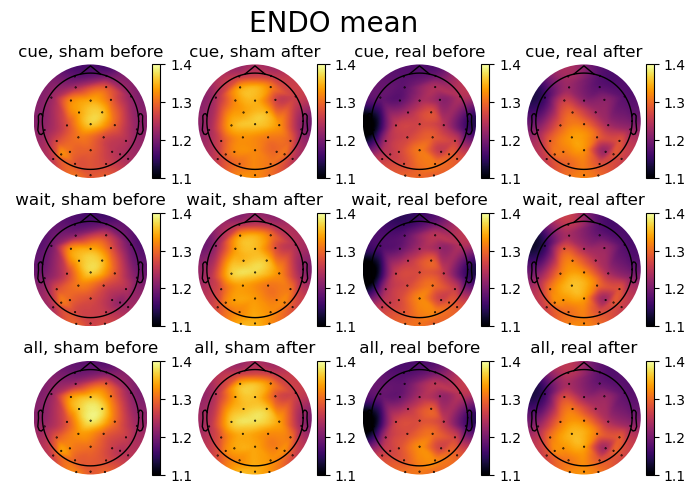

In [40]:
raw = fe.channel_pos()

session_names = ['sham before ', 'sham after ', 'real before ', 'real after ']
stage_names = [' cue', ' wait', ' all']

fig, axes = plt.subplots(nrows=len(stage_names), ncols=len(session_names), figsize=(8, 5))
# cbar_lim = [(0.5, 1.5), (0., 4e-8), (-4e-8, 4e-8), (-2e-8, 2e-8)]

for k, session_name in enumerate(session_names):
    for i, stage_name in enumerate(stage_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(endo_means[k,:,i], pos=raw.info, axes=ax, show=False, cmap='inferno',  contours=0, vlim=(1.1, 1.4))
        # Add title to each subplot
        ax.set_title(stage_name + ', ' + session_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='7%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        # cbar.set_ticks([1, 1.5])


fig.suptitle('ENDO mean', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()

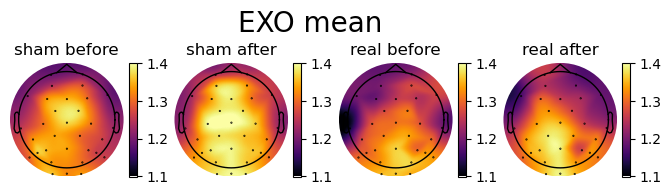

In [51]:
raw = fe.channel_pos()

session_names = ['sham before', 'sham after', 'real before', 'real after']

fig, axes = plt.subplots(ncols=len(session_names), figsize=(8, 5))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(exo_means[k,:], pos=raw.info, axes=ax, show=False, cmap='inferno',  contours=0, vlim=(1.1, 1.4))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('EXO mean', fontsize=20, y=0.75)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()

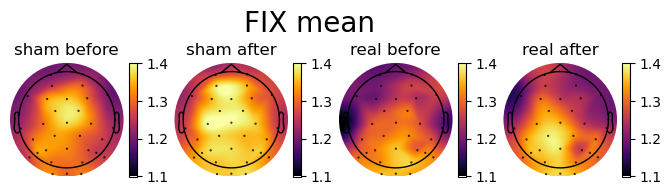

In [53]:
raw = fe.channel_pos()

session_names = ['sham before', 'sham after', 'real before', 'real after']

fig, axes = plt.subplots(ncols=len(session_names), figsize=(8, 5))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(fix_means[k,:], pos=raw.info, axes=ax, show=False, cmap='inferno',  contours=0, vlim=(1.1, 1.4))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('FIX mean', fontsize=20, y=0.75)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()

### DFA subtracts

In [65]:
# np.max(dfa_subtracts_norm), np.min(dfa_subtracts_norm)

(0.10979183391126589, -0.05617448314735399)

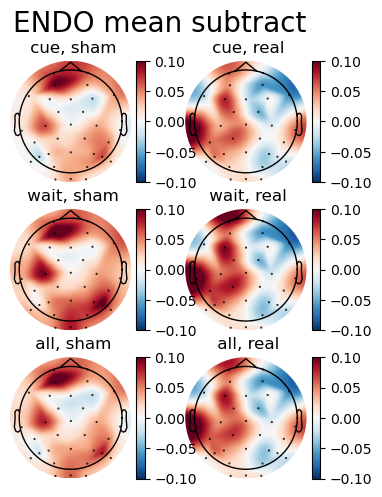

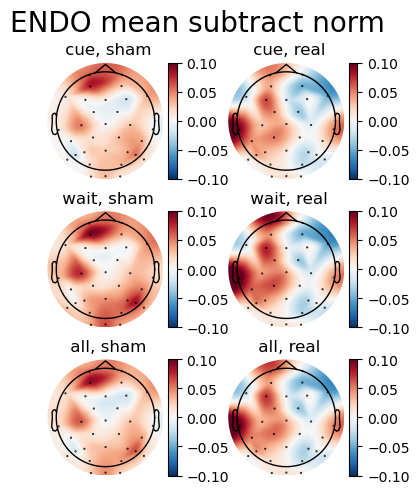

In [109]:
table = endo_means
dfa_subtracts = np.zeros((2, 32, 3))
dfa_subtracts_norm = np.zeros((2, 32, 3))
dfa_subtracts[0,:,:] = table[1,:,:] - table[0,:,:]
dfa_subtracts[1,:,:] = table[3,:,:] - table[2,:,:]
dfa_subtracts_norm[0,:,:] = dfa_subtracts[0,:,:] / table[0,:,:]
dfa_subtracts_norm[1,:,:] = dfa_subtracts[1,:,:] / table[2,:,:]

raw = fe.channel_pos()

session_names = ['sham', 'real']
stage_names = [' cue', ' wait', ' all']

fig, axes = plt.subplots(nrows=len(stage_names), ncols=len(session_names), figsize=(4, 5))

for k, session_name in enumerate(session_names):
    for i, stage_name in enumerate(stage_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(dfa_subtracts[k,:,i], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0 , vlim=(-0.1, 0.1))
        # Add title to each subplot
        ax.set_title(stage_name + ', ' + session_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='7%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        # cbar.set_ticks([1, 1.5])


fig.suptitle('ENDO mean subtract', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=len(stage_names), ncols=len(session_names), figsize=(4, 5))

for k, session_name in enumerate(session_names):
    for i, stage_name in enumerate(stage_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(dfa_subtracts_norm[k,:,i], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0 , vlim=(-0.1, 0.1))
        # Add title to each subplot
        ax.set_title(stage_name + ', ' + session_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='7%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        # cbar.set_ticks([1, 1.5])


fig.suptitle('ENDO mean subtract norm', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.4)
# plt.tight_layout()
plt.show()

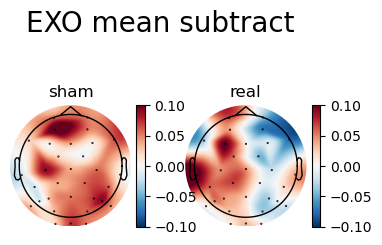

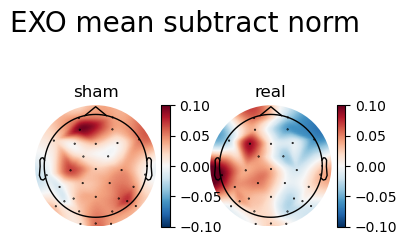

In [110]:
table = exo_means
dfa_subtracts = np.zeros((2, 32))
dfa_subtracts_norm = np.zeros((2, 32))
dfa_subtracts[0,:] = table[1,:] - table[0,:]
dfa_subtracts[1,:] = table[3,:] - table[2,:]
dfa_subtracts_norm[0,:] = dfa_subtracts[0,:] / table[0,:]
dfa_subtracts_norm[1,:] = dfa_subtracts[1,:] / table[2,:]

raw = fe.channel_pos()

session_names = ['sham', 'real']

fig, axes = plt.subplots(nrows=1, ncols=len(session_names), figsize=(4, 3))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(dfa_subtracts[k,:], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0 , vlim=(-0.1, 0.1))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('EXO mean subtract', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=len(session_names), figsize=(4, 3))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(dfa_subtracts_norm[k,:], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0 , vlim=(-0.1, 0.1))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('EXO mean subtract norm', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()

In [111]:
np.max(dfa_subtracts), np.min(dfa_subtracts)

(0.11867665657362347, -0.07850140723328392)

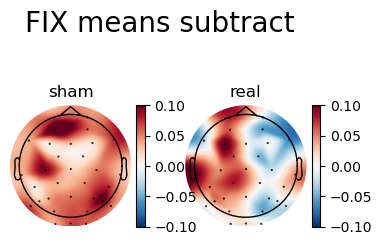

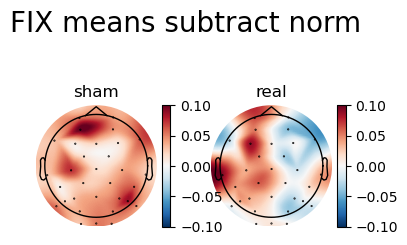

In [112]:
table = fix_means
dfa_subtracts = np.zeros((2, 32))
dfa_subtracts_norm = np.zeros((2, 32))
dfa_subtracts[0,:] = table[1,:] - table[0,:]
dfa_subtracts[1,:] = table[3,:] - table[2,:]
dfa_subtracts_norm[0,:] = dfa_subtracts[0,:] / table[0,:]
dfa_subtracts_norm[1,:] = dfa_subtracts[1,:] / table[2,:]

raw = fe.channel_pos()

session_names = ['sham', 'real']

fig, axes = plt.subplots(nrows=1, ncols=len(session_names), figsize=(4, 3))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(dfa_subtracts[k,:], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0, vlim=(-0.1, 0.1))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('FIX means subtract', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=len(session_names), figsize=(4, 3))

for k, session_name in enumerate(session_names):
    ax = axes[k]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(dfa_subtracts_norm[k,:], pos=raw.info, axes=ax, cmap='RdBu_r', show=False, contours=0, vlim=(-0.1, 0.1))
    # Add title to each subplot
    ax.set_title(session_name)

    # Create an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad=0.05)
    
    # Add the color bar to the current subplot
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    # cbar.set_ticks([1, 1.5])


fig.suptitle('FIX means subtract norm', fontsize=20, y=1.05)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
plt.show()